### Sensitivity Analysis based on Pauline's PPEs

How do ICON-A's tunable parameters affect important metrics in 1-10 year long R2B5 simulations?

In [2]:
import os
import re
import numpy as np
import xarray as xr
import subprocess
import matplotlib.pyplot as plt
import glob
import json
from sklearn.linear_model import LinearRegression

In all_PPEs_results we have the output from many ICON runs.
In the corresponding namelist files we find the setting for the free parameters.

In [3]:
# Data folder
all_PPEs_results = '/work/bd1179/b309216/icon/ICON-2.6.4/2.6.4/experiments/'

In [4]:
def extract_ppe_params_and_metric(ppe_number, free_param, metric):
    '''
        Extracts settings of tunable parameters used for a perticular ICON simulation and the statistic of a given metric/variable previously extracted through 2402_extract_statistics.py

        Based on the PPE we choose (through ppe_number in [1, 10]), the namelists are read to extract the values of the <free_param> (String). These values are stored in x_vals.
        Note that <free_param> must be an element of name_tune_vars.
        In addition, the statistics (means) of the <metric> (String) are read and stored in y_vals.
        These statistics were created with 2402_extract_statistics.py.
    '''
    
    # We have 10 different PPEs. Select the one you want to analyze.
    if ppe_number == 1:
        exp_name = 'atm_amip_R2B5_1979-1990_nrun_'; PPE_name = '-2ndtuningstep_PhyDynParam_4thPPE'
    elif ppe_number == 2:
        exp_name = 'atm_amip_R2B5_1979-1990_nrun_'; PPE_name = '-2ndtuningstep_PhyDynParam_5thPPE'
    elif ppe_number == 3:
        exp_name = 'atm_amip_R2B5_1979-1990_nrun_'; PPE_name = '-2ndtuningstep_PhyDynParam_NewParam'
    elif ppe_number == 4:
        exp_name = 'atm_amip_R2B5_1979-1990_nrun_'; PPE_name = '-2ndtuningstep_OtherClOptim'
    elif ppe_number == 5:
        exp_name = 'atm_amip_R2B5_1979-1990_nrun_'; PPE_name = '-2ndtuningstep'
    elif ppe_number == 6:
        exp_name = 'atm_amip_R2B5_1979-1981_nrun_'; PPE_name = '-LHCsampling'
    elif ppe_number == 7:
        exp_name = 'atm_amip_R2B5_1979-1981_nrun_'; PPE_name = '-2ndLHCsampling'
    elif ppe_number == 8:
        exp_name = 'atm_amip_R2B5_1979-1981_nrun_'; PPE_name = '-3rdLHCsampling'
    elif ppe_number == 9:
        exp_name = 'atm_amip_R2B5_1979-1981_nrun_'; PPE_name = '-4thLHCsampling'
    elif ppe_number == 10:
        exp_name = 'atm_amip_R2B5_1979-1981_nrun_'; PPE_name = '-5thLHCsampling'

    # Extract the numbers all runs corresponding to a given PPE
    listallfolders = [f for f in os.listdir(all_PPEs_results) if (f.startswith(exp_name) and f.endswith(PPE_name))]
    listallruns = []
    for fname in listallfolders:
        res = re.findall(exp_name + "(\S+)" + PPE_name, fname)
        if not res or len(glob.glob(all_PPEs_results + fname + '/*atm_2d*.nc')) < 5:
            continue
        listallruns.append(res[0])

    name_tune_vars = ['rmscon', # gwd in [m/s]
                    'gkdrag', 'gkwake', # sso 
                    'gpicmea', 'gstd', # sso in [m]
                    'pr0', # vdf
                    'entrmid', 'entrpen', 'entrdd', 'cmftau', # cnv
                    'cvtfall', # cld
                    'crt', 'crs', 'csatsc'] # cov

    # Add default values for the variables for when they are missing from the namelist!!
    default_vals = [0.87, 0.05, 0, 40, 10, 1, 2e-4, 2e-4, 4e-4, 3600, 2.5, 0.8, 0.968, 0.7] 

    # Extracting the setting of the free parameters from the namelist file 
    parameters_all_members = dict()
    for i in range(0,len(listallruns)):
        folder_name = all_PPEs_results + exp_name + listallruns[i] + PPE_name + '/'
        namelist = 'NAMELIST_' + exp_name + listallruns[i] + PPE_name + '_atm'
        
        # Initiate dictionary with default values for each tunable variable
        parameters_member = {name_tune_vars[i]: default_vals[i] for i in range(len(name_tune_vars))}

        with open(folder_name + namelist) as f:
            lines = f.readlines()
            for line in lines:
                for j in range(0,len(name_tune_vars)):
                    var = name_tune_vars[j]
                    if var in line:
                        res = line.split(var,1)[1]
                        res = line.split('=',1)[1]
                        res = re.findall(r'\S+', res)[0]
                        value = np.float64(res)
                        parameters_member[var] = value
        parameters_all_members[listallruns[i]] = parameters_member

    # print(parameters_all_members)

    x_vals = []
    y_vals = []

    for i in range(len(listallruns)):
        x_vals.append(parameters_all_members[listallruns[i]][free_param])
        y_val = xr.open_dataset('/work/bd1179/b309170/icon-ml_models/tuning/statistics_exp_pauline/%s%s%s_%s.nc'%(exp_name, listallruns[i], PPE_name, metric))
        # The parameter name is incorrect for net_SW, SCRE and TOA_balance
        if metric in ['net_SW', 'TOA_balance']:
            y_vals.append(getattr(y_val, 'rsdt').values.item())
        elif metric in ['SCRE']:
            y_vals.append(getattr(y_val, 'rsutcs').values.item())
        else:
            y_vals.append(getattr(y_val, metric).values.item())

    return x_vals, y_vals

In [15]:
def create_sensitivity_plot(metric, metric_with_unit):
    # Reading all results
    free_params = ['rmscon', # gwd in [m/s]
                        'gkdrag', 'gkwake', # sso 
                        'gpicmea', 'gstd', # sso in [m]
                        'pr0', # vdf
                        'entrmid', 'entrpen', 'entrdd', 'cmftau', # cnv
                        'cvtfall', # cld
                        'crt', 'crs', 'csatsc'] # cov
    free_params_with_unit = ['rmscon [m/s]',  'gkdrag []',  'gkwake []',  'gpicmea [m]',  'gstd [m]',  'pr0 []',  'entrmid []',  'entrpen []',  'entrdd []',  \
                            'cmftau []',  'cvtfall []',  'crt []',  'crs []',  'csatsc []']

    # Setting up the figure
    plt.figure(figsize=(20, 15))
    plt.subplots_adjust(hspace=0.4)
    plt.suptitle("Sensitivity of averaged %s w.r.t. tunable parameters"%metric, fontsize=18, y=.91)

    # Setting up dict to store sign. slopes
    slopes_dict = {}
    slopes_dict[metric] = {}

    for i, free_param in enumerate(free_params):

        x_vals = []
        y_vals = []

        # Add new subplot iteratively
        ax = plt.subplot(5, 3, i + 1)

        for ppe in range(1, 11):
            try:
                x_vals_ppe, y_vals_ppe = extract_ppe_params_and_metric(ppe, free_param, metric)
                if len(x_vals) > 0:
                    x_vals = np.concatenate((x_vals, x_vals_ppe))
                    y_vals = np.concatenate((y_vals, y_vals_ppe))
                else:
                    x_vals = x_vals_ppe
                    y_vals = y_vals_ppe
            except:
                print('PPE %d skipped.'%ppe)

        # Plotting
        ax.plot(x_vals, y_vals, 'b.')
        plt.xlabel(free_params_with_unit[i])
        plt.ylabel(metric_with_unit)
        
        # Adjust the ylim for each metric
        if metric == 'rlut':
            ylim_min, ylim_max = [200, 250]
        elif metric == 'rsut':
            ylim_min, ylim_max = [80, 140]
        elif metric == 'rsdt':
            ylim_min, ylim_max = [300, 400]
        elif metric == 'clt':
            ylim_min, ylim_max = [0.4, 1]
        elif metric == 'cllvi':
            ylim_min, ylim_max = [0, 0.2]
        elif metric == 'clivi':
            ylim_min, ylim_max = [0.02, 0.08]
        elif metric == 'prw':
            ylim_min, ylim_max = [10, 40]
        elif metric == 'pr':
            ylim_min, ylim_max = [2e-5, 5e-5]
        elif metric == 'net_SW':
            ylim_min, ylim_max = [200, 250]
        elif metric == 'SCRE':
            ylim_min, ylim_max = [-80, 10]
        elif metric == 'TOA_balance':
            ylim_min, ylim_max = [-20, 20]

        plt.ylim([ylim_min, ylim_max])

        # Add linear regression line
        x_vals_cleaned = x_vals[np.array(ylim_min < y_vals) & np.array(y_vals < ylim_max)]
        y_vals_cleaned = y_vals[np.array(ylim_min < y_vals) & np.array(y_vals < ylim_max)]

        reg = LinearRegression().fit(x_vals_cleaned.reshape(-1, 1), y_vals_cleaned)
        X_lin = np.linspace(np.min(x_vals), np.max(x_vals), 100)
        plt.plot(X_lin, reg.coef_[0]*X_lin+reg.intercept_)

        # Add the (linear) correlation coefficient as a number to the plot
        corr_coef = np.corrcoef(x_vals_cleaned, y_vals_cleaned)[0, 1]
        plt.text(np.min(x_vals), ylim_max - (ylim_max - ylim_min)/10, '%.4g'%corr_coef, color='olive')
        # Add slope of the regression line as a number to the plot
        reg_slope = reg.coef_[0]
        plt.text(np.min(x_vals), ylim_max - (ylim_max - ylim_min)/5, '%.4g'%reg_slope, color='brown')

        # Save all the slopes for significant correlations
        if np.abs(corr_coef) > 0.2:
            slopes_dict[metric][free_param] = reg_slope

    # Write a json file with all the slopes for significant correlations
    try:
        with open('plots_sensitivity_analysis/reg_slopes.json', 'r') as file:
            json_content = json.load(file)
        for key in json_content.keys():
            slopes_dict[key] = json_content[key]
    finally:
        with open('plots_sensitivity_analysis/reg_slopes.json', 'w') as file:
            json.dump(slopes_dict, file, indent=4)

    # # Save sensitivity plot
    # plt.savefig('plots_sensitivity_analysis/%s.pdf'%metric)

PPE 3 skipped.


HDF5-DIAG: Error detected in HDF5 (1.10.6) thread 140737354035840:
  #000: H5O.c line 120 in H5Oopen(): unable to open object
    major: Object header
    minor: Can't open object
  #001: H5Oint.c line 637 in H5O_open_name(): unable to open object
    major: Object header
    minor: Can't open object
  #002: H5Oint.c line 768 in H5O__open_by_loc(): unable to determine object class
    major: Object header
    minor: Can't get value
  #003: H5Oint.c line 1751 in H5O__obj_class(): unable to load object header
    major: Object header
    minor: Unable to protect metadata
  #004: H5Oint.c line 1066 in H5O_protect(): unable to load object header
    major: Object header
    minor: Unable to protect metadata
  #005: H5AC.c line 1352 in H5AC_protect(): H5C_protect() failed
    major: Object cache
    minor: Unable to protect metadata
  #006: H5C.c line 2345 in H5C_protect(): can't load entry
    major: Object cache
    minor: Unable to load metadata into cache
  #007: H5C.c line 6685 in H5C_

PPE 3 skipped.


HDF5-DIAG: Error detected in HDF5 (1.10.6) thread 140737354035840:
  #000: H5O.c line 120 in H5Oopen(): unable to open object
    major: Object header
    minor: Can't open object
  #001: H5Oint.c line 637 in H5O_open_name(): unable to open object
    major: Object header
    minor: Can't open object
  #002: H5Oint.c line 768 in H5O__open_by_loc(): unable to determine object class
    major: Object header
    minor: Can't get value
  #003: H5Oint.c line 1751 in H5O__obj_class(): unable to load object header
    major: Object header
    minor: Unable to protect metadata
  #004: H5Oint.c line 1066 in H5O_protect(): unable to load object header
    major: Object header
    minor: Unable to protect metadata
  #005: H5AC.c line 1352 in H5AC_protect(): H5C_protect() failed
    major: Object cache
    minor: Unable to protect metadata
  #006: H5C.c line 2345 in H5C_protect(): can't load entry
    major: Object cache
    minor: Unable to load metadata into cache
  #007: H5C.c line 6685 in H5C_

PPE 3 skipped.


HDF5-DIAG: Error detected in HDF5 (1.10.6) thread 140737354035840:
  #000: H5O.c line 120 in H5Oopen(): unable to open object
    major: Object header
    minor: Can't open object
  #001: H5Oint.c line 637 in H5O_open_name(): unable to open object
    major: Object header
    minor: Can't open object
  #002: H5Oint.c line 768 in H5O__open_by_loc(): unable to determine object class
    major: Object header
    minor: Can't get value
  #003: H5Oint.c line 1751 in H5O__obj_class(): unable to load object header
    major: Object header
    minor: Unable to protect metadata
  #004: H5Oint.c line 1066 in H5O_protect(): unable to load object header
    major: Object header
    minor: Unable to protect metadata
  #005: H5AC.c line 1352 in H5AC_protect(): H5C_protect() failed
    major: Object cache
    minor: Unable to protect metadata
  #006: H5C.c line 2345 in H5C_protect(): can't load entry
    major: Object cache
    minor: Unable to load metadata into cache
  #007: H5C.c line 6685 in H5C_

PPE 3 skipped.


HDF5-DIAG: Error detected in HDF5 (1.10.6) thread 140737354035840:
  #000: H5O.c line 120 in H5Oopen(): unable to open object
    major: Object header
    minor: Can't open object
  #001: H5Oint.c line 637 in H5O_open_name(): unable to open object
    major: Object header
    minor: Can't open object
  #002: H5Oint.c line 768 in H5O__open_by_loc(): unable to determine object class
    major: Object header
    minor: Can't get value
  #003: H5Oint.c line 1751 in H5O__obj_class(): unable to load object header
    major: Object header
    minor: Unable to protect metadata
  #004: H5Oint.c line 1066 in H5O_protect(): unable to load object header
    major: Object header
    minor: Unable to protect metadata
  #005: H5AC.c line 1352 in H5AC_protect(): H5C_protect() failed
    major: Object cache
    minor: Unable to protect metadata
  #006: H5C.c line 2345 in H5C_protect(): can't load entry
    major: Object cache
    minor: Unable to load metadata into cache
  #007: H5C.c line 6685 in H5C_

PPE 3 skipped.


HDF5-DIAG: Error detected in HDF5 (1.10.6) thread 140737354035840:
  #000: H5O.c line 120 in H5Oopen(): unable to open object
    major: Object header
    minor: Can't open object
  #001: H5Oint.c line 637 in H5O_open_name(): unable to open object
    major: Object header
    minor: Can't open object
  #002: H5Oint.c line 768 in H5O__open_by_loc(): unable to determine object class
    major: Object header
    minor: Can't get value
  #003: H5Oint.c line 1751 in H5O__obj_class(): unable to load object header
    major: Object header
    minor: Unable to protect metadata
  #004: H5Oint.c line 1066 in H5O_protect(): unable to load object header
    major: Object header
    minor: Unable to protect metadata
  #005: H5AC.c line 1352 in H5AC_protect(): H5C_protect() failed
    major: Object cache
    minor: Unable to protect metadata
  #006: H5C.c line 2345 in H5C_protect(): can't load entry
    major: Object cache
    minor: Unable to load metadata into cache
  #007: H5C.c line 6685 in H5C_

PPE 3 skipped.


HDF5-DIAG: Error detected in HDF5 (1.10.6) thread 140737354035840:
  #000: H5O.c line 120 in H5Oopen(): unable to open object
    major: Object header
    minor: Can't open object
  #001: H5Oint.c line 637 in H5O_open_name(): unable to open object
    major: Object header
    minor: Can't open object
  #002: H5Oint.c line 768 in H5O__open_by_loc(): unable to determine object class
    major: Object header
    minor: Can't get value
  #003: H5Oint.c line 1751 in H5O__obj_class(): unable to load object header
    major: Object header
    minor: Unable to protect metadata
  #004: H5Oint.c line 1066 in H5O_protect(): unable to load object header
    major: Object header
    minor: Unable to protect metadata
  #005: H5AC.c line 1352 in H5AC_protect(): H5C_protect() failed
    major: Object cache
    minor: Unable to protect metadata
  #006: H5C.c line 2345 in H5C_protect(): can't load entry
    major: Object cache
    minor: Unable to load metadata into cache
  #007: H5C.c line 6685 in H5C_

PPE 3 skipped.


HDF5-DIAG: Error detected in HDF5 (1.10.6) thread 140737354035840:
  #000: H5O.c line 120 in H5Oopen(): unable to open object
    major: Object header
    minor: Can't open object
  #001: H5Oint.c line 637 in H5O_open_name(): unable to open object
    major: Object header
    minor: Can't open object
  #002: H5Oint.c line 768 in H5O__open_by_loc(): unable to determine object class
    major: Object header
    minor: Can't get value
  #003: H5Oint.c line 1751 in H5O__obj_class(): unable to load object header
    major: Object header
    minor: Unable to protect metadata
  #004: H5Oint.c line 1066 in H5O_protect(): unable to load object header
    major: Object header
    minor: Unable to protect metadata
  #005: H5AC.c line 1352 in H5AC_protect(): H5C_protect() failed
    major: Object cache
    minor: Unable to protect metadata
  #006: H5C.c line 2345 in H5C_protect(): can't load entry
    major: Object cache
    minor: Unable to load metadata into cache
  #007: H5C.c line 6685 in H5C_

PPE 3 skipped.


HDF5-DIAG: Error detected in HDF5 (1.10.6) thread 140737354035840:
  #000: H5O.c line 120 in H5Oopen(): unable to open object
    major: Object header
    minor: Can't open object
  #001: H5Oint.c line 637 in H5O_open_name(): unable to open object
    major: Object header
    minor: Can't open object
  #002: H5Oint.c line 768 in H5O__open_by_loc(): unable to determine object class
    major: Object header
    minor: Can't get value
  #003: H5Oint.c line 1751 in H5O__obj_class(): unable to load object header
    major: Object header
    minor: Unable to protect metadata
  #004: H5Oint.c line 1066 in H5O_protect(): unable to load object header
    major: Object header
    minor: Unable to protect metadata
  #005: H5AC.c line 1352 in H5AC_protect(): H5C_protect() failed
    major: Object cache
    minor: Unable to protect metadata
  #006: H5C.c line 2345 in H5C_protect(): can't load entry
    major: Object cache
    minor: Unable to load metadata into cache
  #007: H5C.c line 6685 in H5C_

PPE 3 skipped.


HDF5-DIAG: Error detected in HDF5 (1.10.6) thread 140737354035840:
  #000: H5O.c line 120 in H5Oopen(): unable to open object
    major: Object header
    minor: Can't open object
  #001: H5Oint.c line 637 in H5O_open_name(): unable to open object
    major: Object header
    minor: Can't open object
  #002: H5Oint.c line 768 in H5O__open_by_loc(): unable to determine object class
    major: Object header
    minor: Can't get value
  #003: H5Oint.c line 1751 in H5O__obj_class(): unable to load object header
    major: Object header
    minor: Unable to protect metadata
  #004: H5Oint.c line 1066 in H5O_protect(): unable to load object header
    major: Object header
    minor: Unable to protect metadata
  #005: H5AC.c line 1352 in H5AC_protect(): H5C_protect() failed
    major: Object cache
    minor: Unable to protect metadata
  #006: H5C.c line 2345 in H5C_protect(): can't load entry
    major: Object cache
    minor: Unable to load metadata into cache
  #007: H5C.c line 6685 in H5C_

PPE 3 skipped.


HDF5-DIAG: Error detected in HDF5 (1.10.6) thread 140737354035840:
  #000: H5O.c line 120 in H5Oopen(): unable to open object
    major: Object header
    minor: Can't open object
  #001: H5Oint.c line 637 in H5O_open_name(): unable to open object
    major: Object header
    minor: Can't open object
  #002: H5Oint.c line 768 in H5O__open_by_loc(): unable to determine object class
    major: Object header
    minor: Can't get value
  #003: H5Oint.c line 1751 in H5O__obj_class(): unable to load object header
    major: Object header
    minor: Unable to protect metadata
  #004: H5Oint.c line 1066 in H5O_protect(): unable to load object header
    major: Object header
    minor: Unable to protect metadata
  #005: H5AC.c line 1352 in H5AC_protect(): H5C_protect() failed
    major: Object cache
    minor: Unable to protect metadata
  #006: H5C.c line 2345 in H5C_protect(): can't load entry
    major: Object cache
    minor: Unable to load metadata into cache
  #007: H5C.c line 6685 in H5C_

PPE 3 skipped.


HDF5-DIAG: Error detected in HDF5 (1.10.6) thread 140737354035840:
  #000: H5O.c line 120 in H5Oopen(): unable to open object
    major: Object header
    minor: Can't open object
  #001: H5Oint.c line 637 in H5O_open_name(): unable to open object
    major: Object header
    minor: Can't open object
  #002: H5Oint.c line 768 in H5O__open_by_loc(): unable to determine object class
    major: Object header
    minor: Can't get value
  #003: H5Oint.c line 1751 in H5O__obj_class(): unable to load object header
    major: Object header
    minor: Unable to protect metadata
  #004: H5Oint.c line 1066 in H5O_protect(): unable to load object header
    major: Object header
    minor: Unable to protect metadata
  #005: H5AC.c line 1352 in H5AC_protect(): H5C_protect() failed
    major: Object cache
    minor: Unable to protect metadata
  #006: H5C.c line 2345 in H5C_protect(): can't load entry
    major: Object cache
    minor: Unable to load metadata into cache
  #007: H5C.c line 6685 in H5C_

PPE 3 skipped.


HDF5-DIAG: Error detected in HDF5 (1.10.6) thread 140737354035840:
  #000: H5O.c line 120 in H5Oopen(): unable to open object
    major: Object header
    minor: Can't open object
  #001: H5Oint.c line 637 in H5O_open_name(): unable to open object
    major: Object header
    minor: Can't open object
  #002: H5Oint.c line 768 in H5O__open_by_loc(): unable to determine object class
    major: Object header
    minor: Can't get value
  #003: H5Oint.c line 1751 in H5O__obj_class(): unable to load object header
    major: Object header
    minor: Unable to protect metadata
  #004: H5Oint.c line 1066 in H5O_protect(): unable to load object header
    major: Object header
    minor: Unable to protect metadata
  #005: H5AC.c line 1352 in H5AC_protect(): H5C_protect() failed
    major: Object cache
    minor: Unable to protect metadata
  #006: H5C.c line 2345 in H5C_protect(): can't load entry
    major: Object cache
    minor: Unable to load metadata into cache
  #007: H5C.c line 6685 in H5C_

PPE 3 skipped.


HDF5-DIAG: Error detected in HDF5 (1.10.6) thread 140737354035840:
  #000: H5O.c line 120 in H5Oopen(): unable to open object
    major: Object header
    minor: Can't open object
  #001: H5Oint.c line 637 in H5O_open_name(): unable to open object
    major: Object header
    minor: Can't open object
  #002: H5Oint.c line 768 in H5O__open_by_loc(): unable to determine object class
    major: Object header
    minor: Can't get value
  #003: H5Oint.c line 1751 in H5O__obj_class(): unable to load object header
    major: Object header
    minor: Unable to protect metadata
  #004: H5Oint.c line 1066 in H5O_protect(): unable to load object header
    major: Object header
    minor: Unable to protect metadata
  #005: H5AC.c line 1352 in H5AC_protect(): H5C_protect() failed
    major: Object cache
    minor: Unable to protect metadata
  #006: H5C.c line 2345 in H5C_protect(): can't load entry
    major: Object cache
    minor: Unable to load metadata into cache
  #007: H5C.c line 6685 in H5C_

PPE 3 skipped.


HDF5-DIAG: Error detected in HDF5 (1.10.6) thread 140737354035840:
  #000: H5O.c line 120 in H5Oopen(): unable to open object
    major: Object header
    minor: Can't open object
  #001: H5Oint.c line 637 in H5O_open_name(): unable to open object
    major: Object header
    minor: Can't open object
  #002: H5Oint.c line 768 in H5O__open_by_loc(): unable to determine object class
    major: Object header
    minor: Can't get value
  #003: H5Oint.c line 1751 in H5O__obj_class(): unable to load object header
    major: Object header
    minor: Unable to protect metadata
  #004: H5Oint.c line 1066 in H5O_protect(): unable to load object header
    major: Object header
    minor: Unable to protect metadata
  #005: H5AC.c line 1352 in H5AC_protect(): H5C_protect() failed
    major: Object cache
    minor: Unable to protect metadata
  #006: H5C.c line 2345 in H5C_protect(): can't load entry
    major: Object cache
    minor: Unable to load metadata into cache
  #007: H5C.c line 6685 in H5C_

PPE 3 skipped.
PPE 3 skipped.
PPE 3 skipped.
PPE 3 skipped.
PPE 3 skipped.
PPE 3 skipped.
PPE 3 skipped.
PPE 3 skipped.
PPE 3 skipped.
PPE 3 skipped.
PPE 3 skipped.
PPE 3 skipped.
PPE 3 skipped.
PPE 3 skipped.
PPE 3 skipped.
PPE 3 skipped.
PPE 3 skipped.
PPE 3 skipped.
PPE 3 skipped.
PPE 3 skipped.
PPE 3 skipped.
PPE 3 skipped.
PPE 3 skipped.
PPE 3 skipped.
PPE 3 skipped.
PPE 3 skipped.
PPE 3 skipped.
PPE 3 skipped.


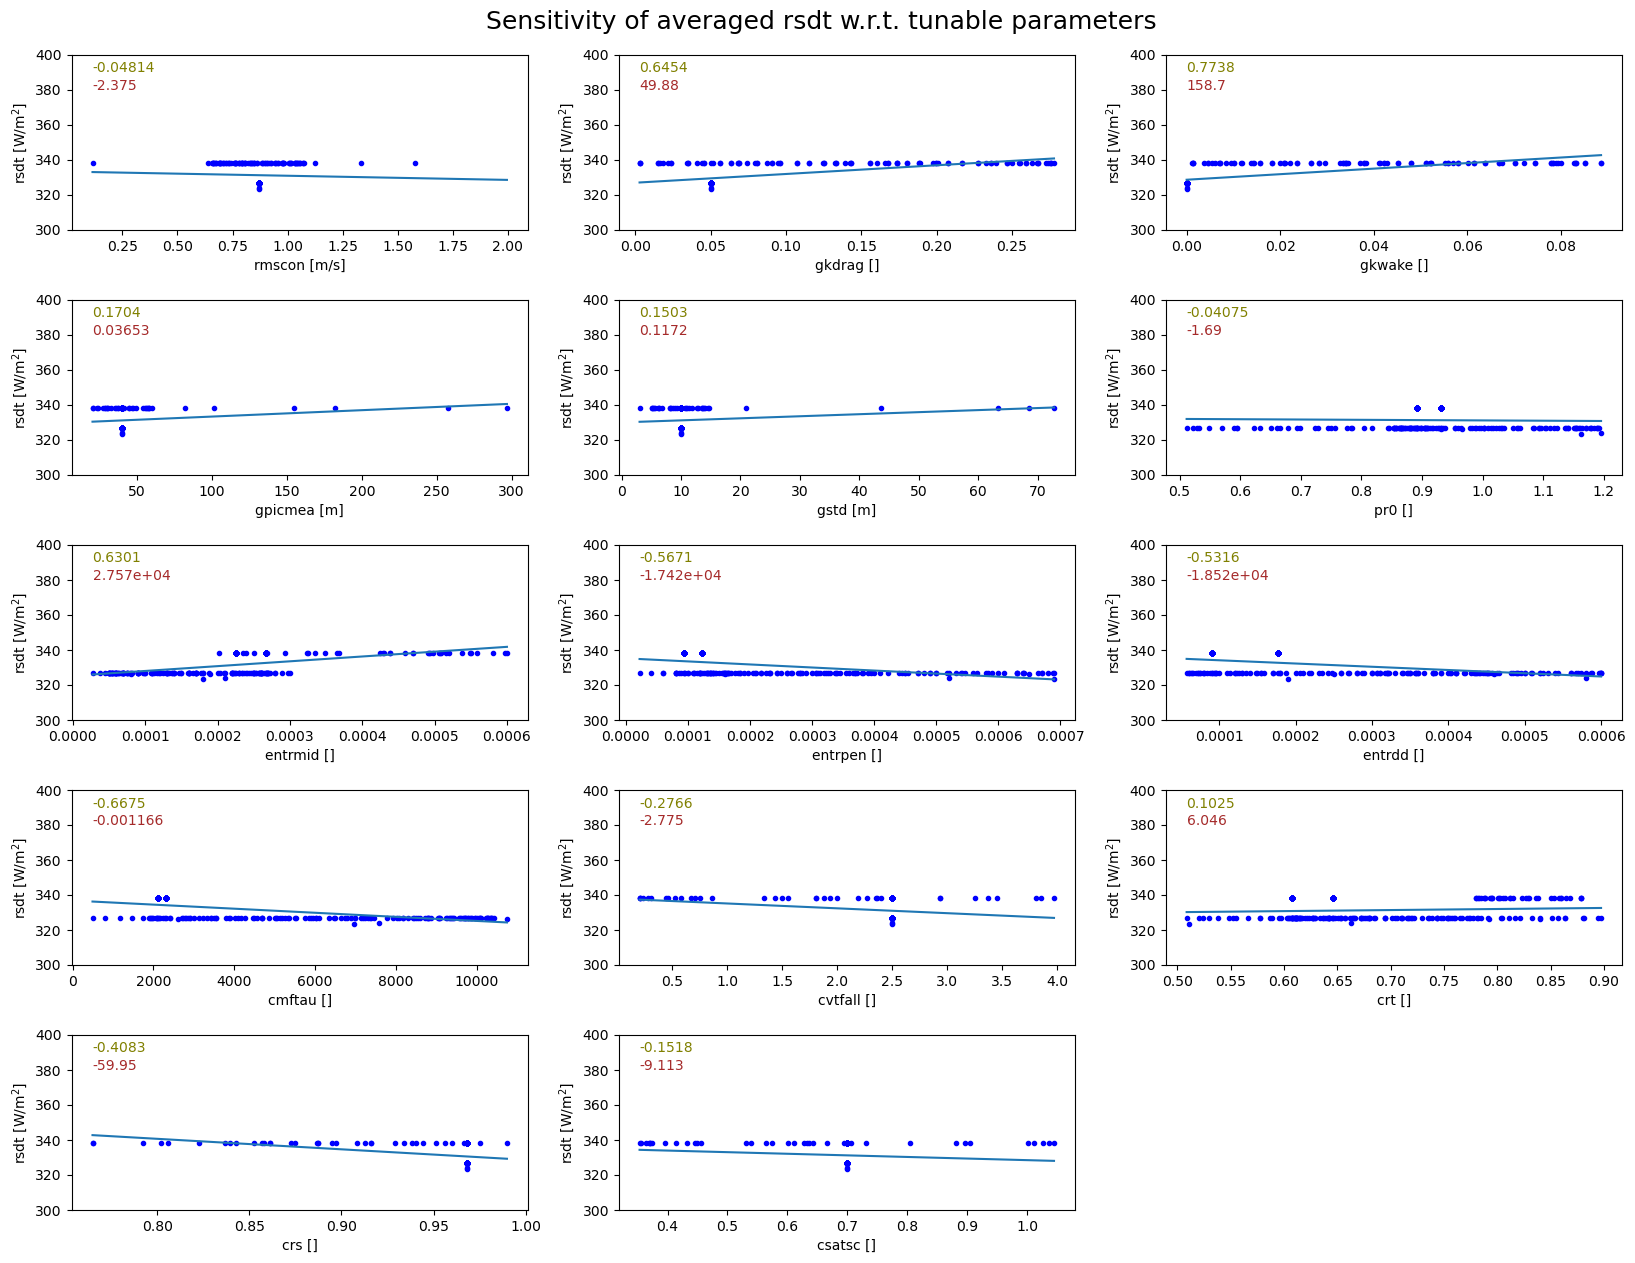

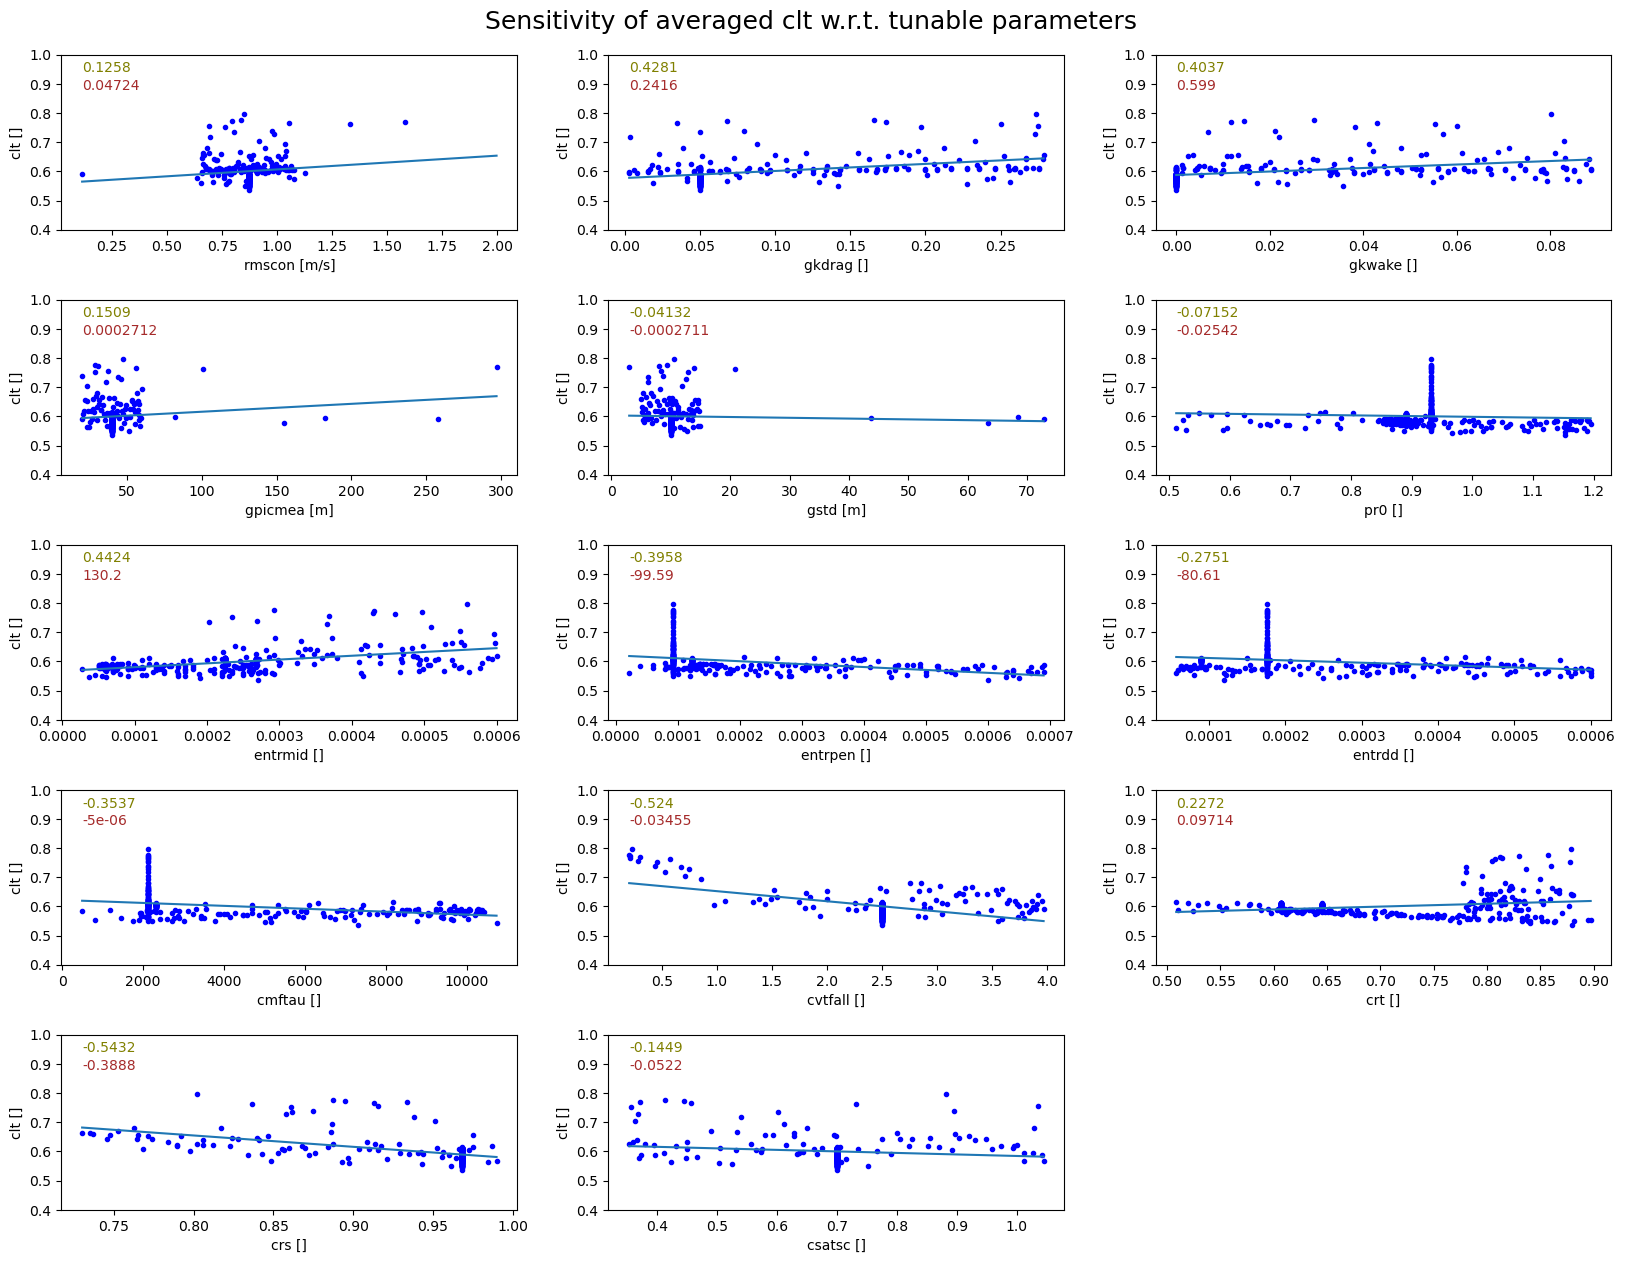

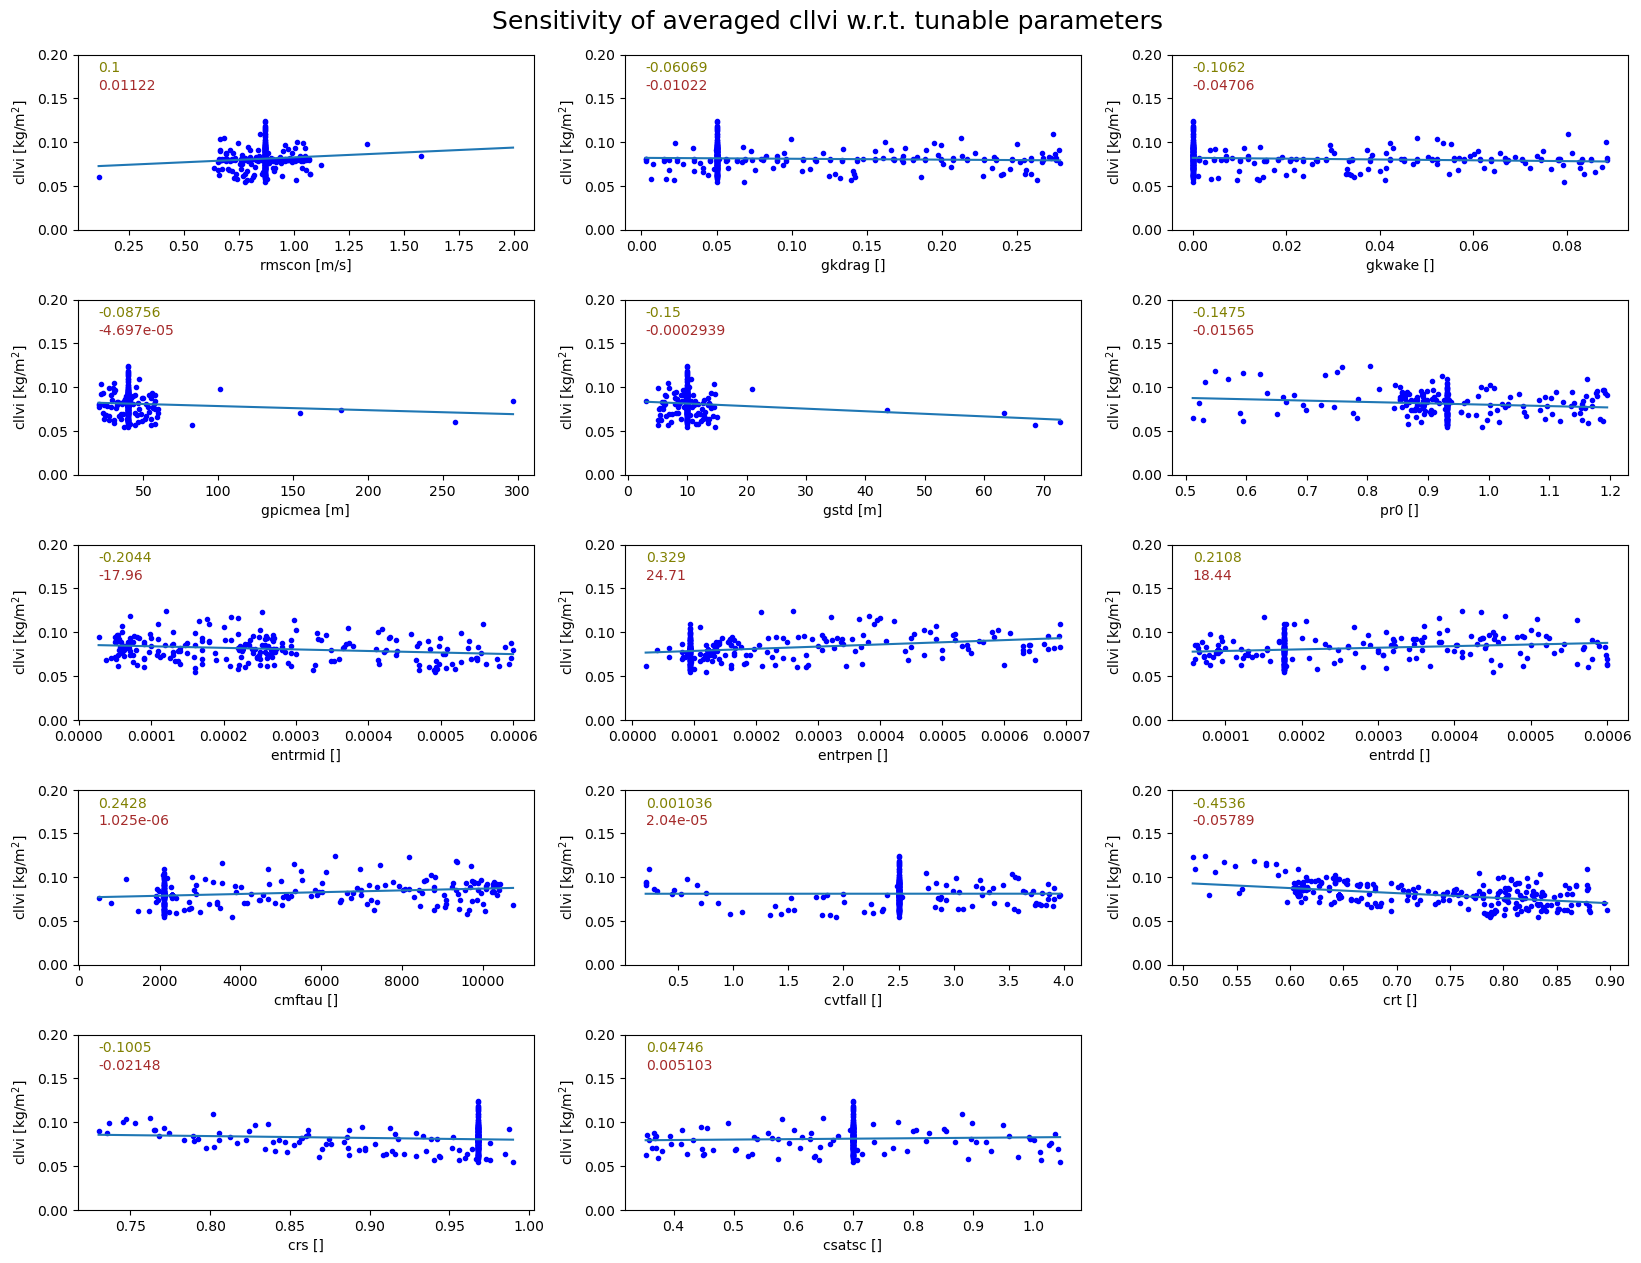

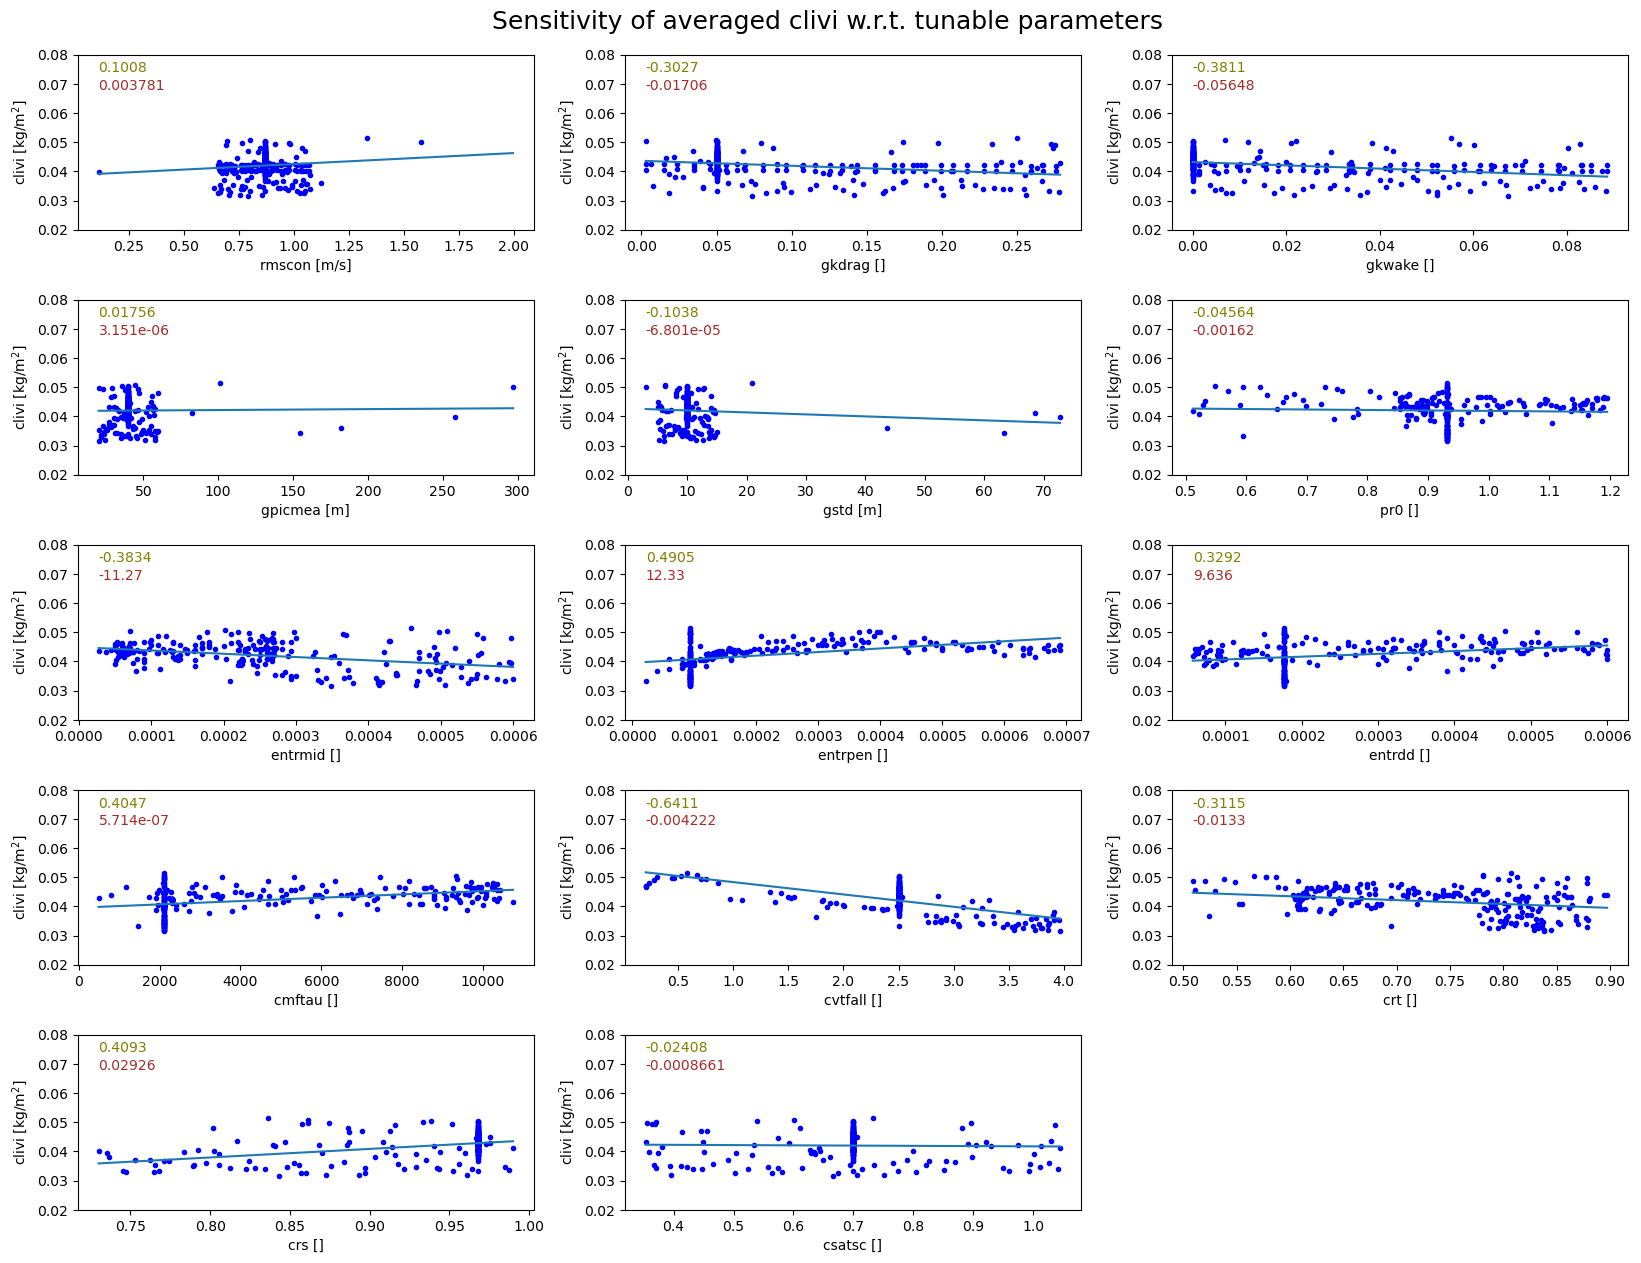

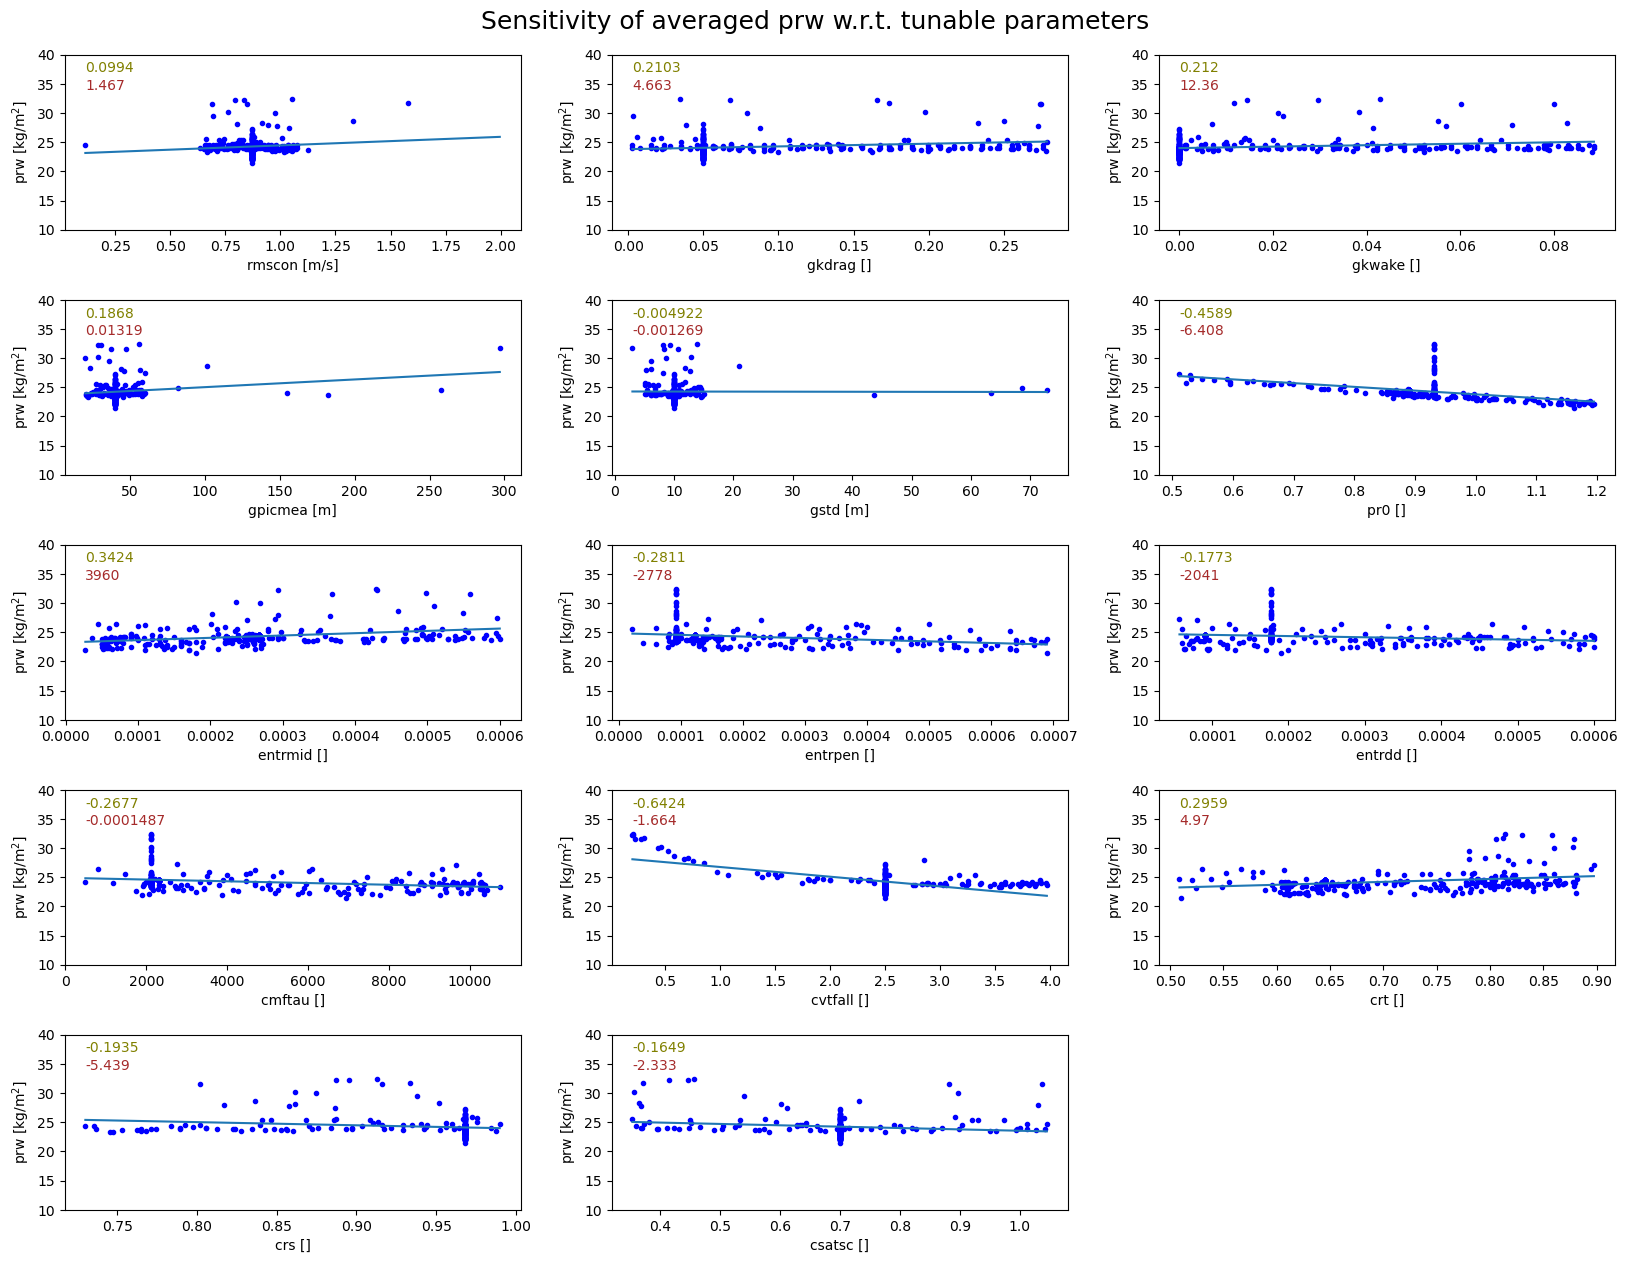

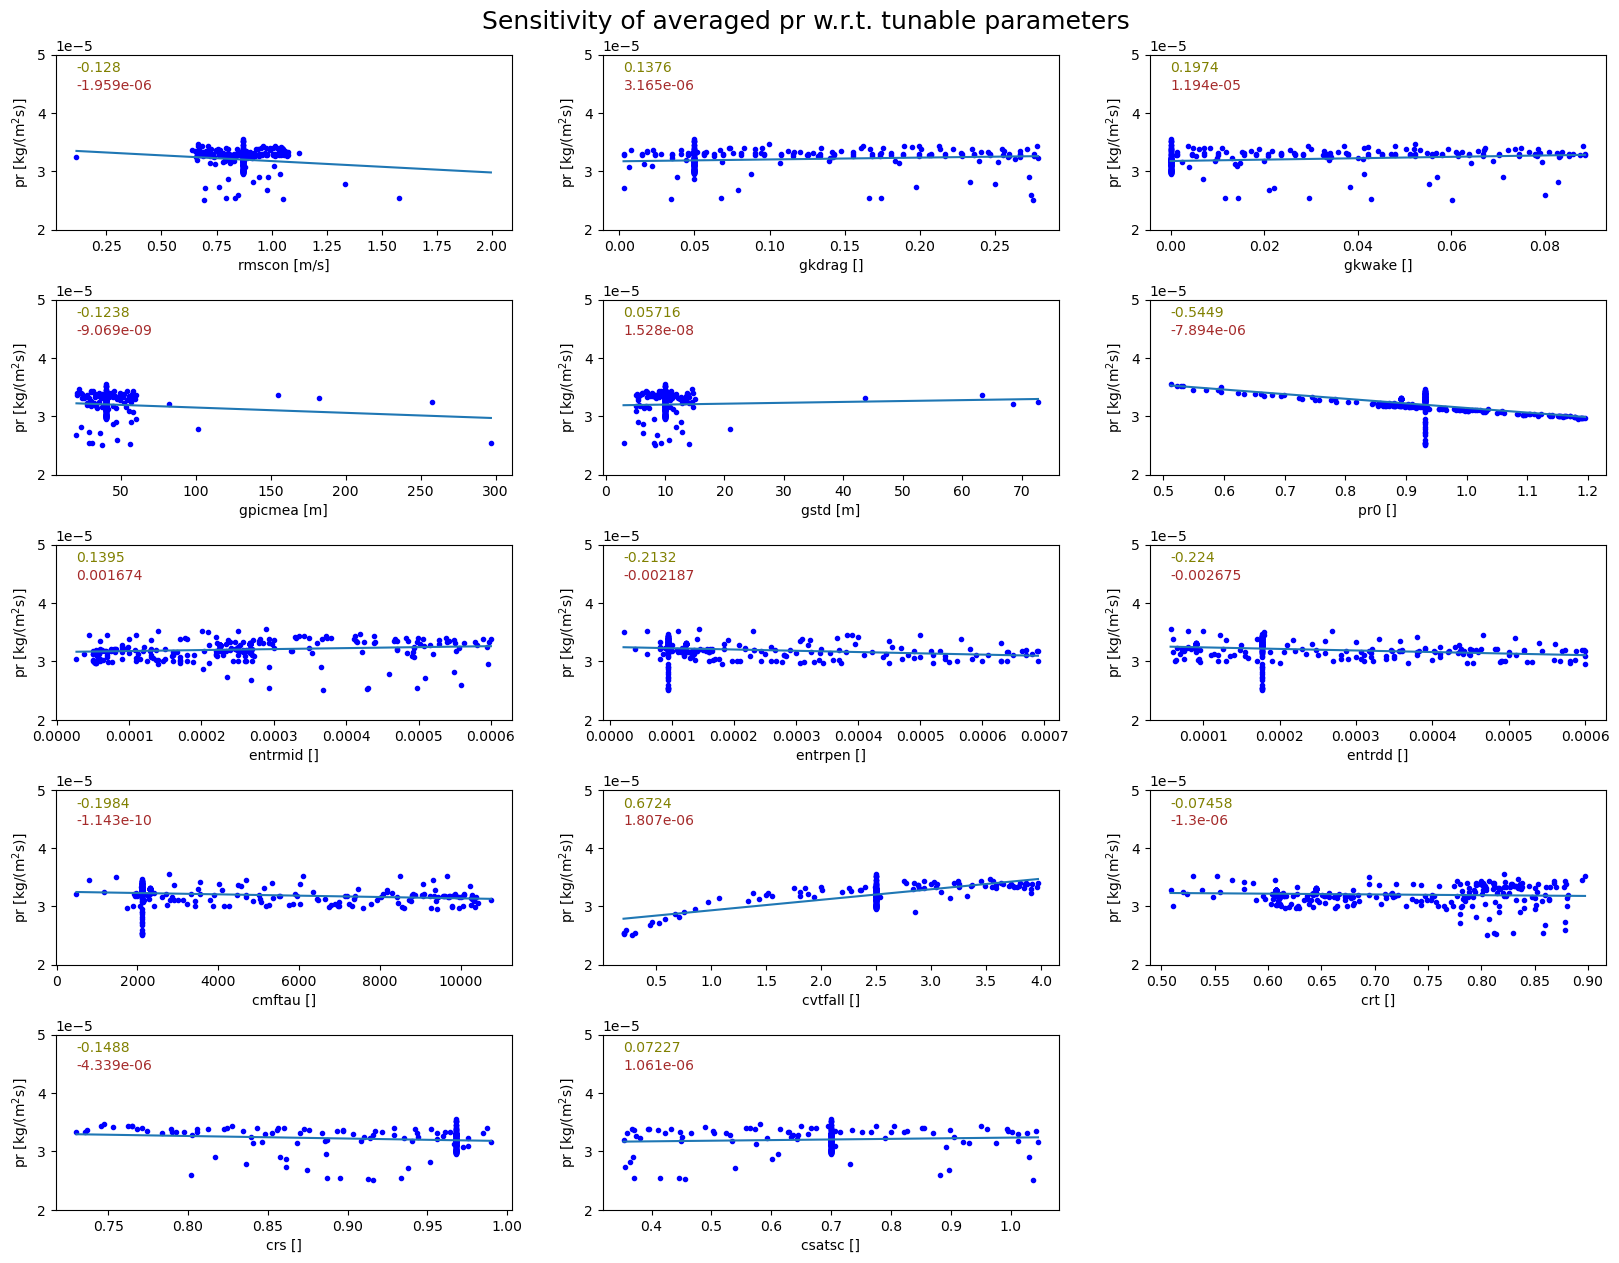

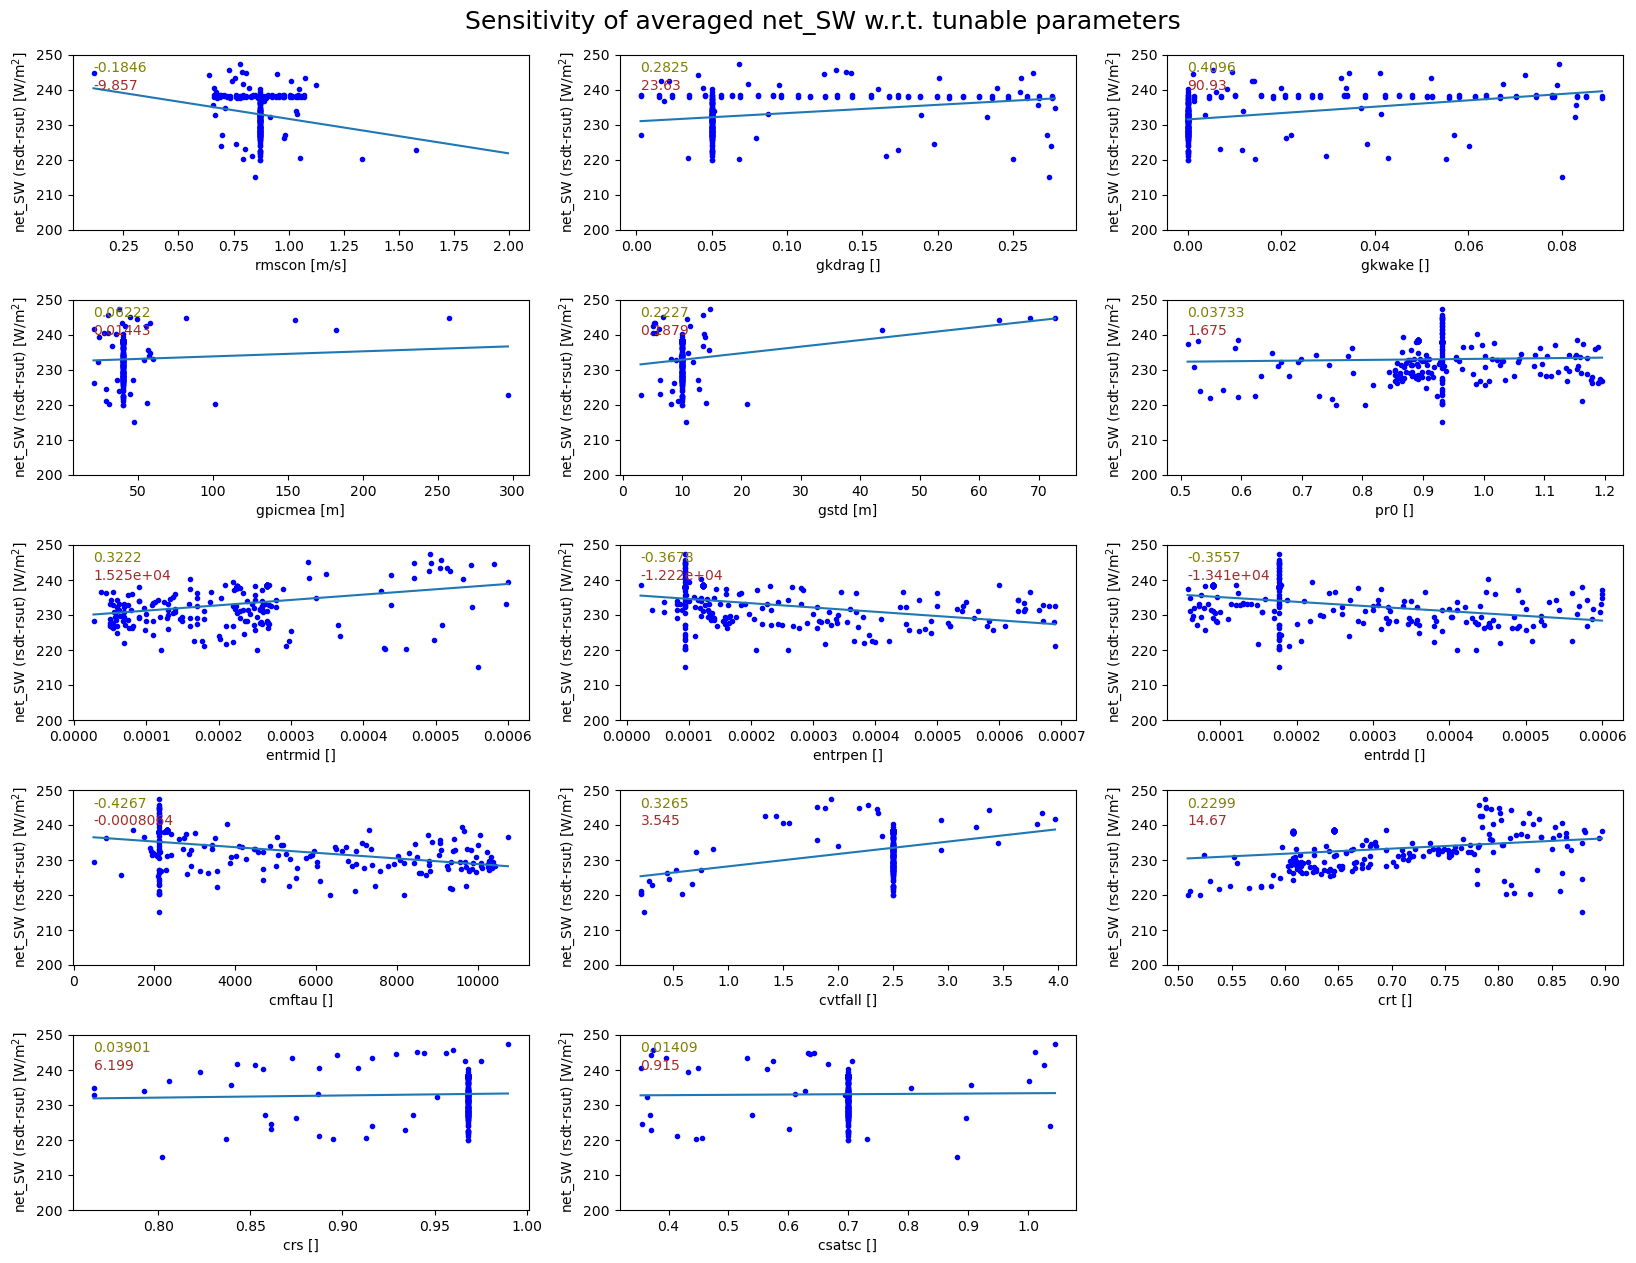

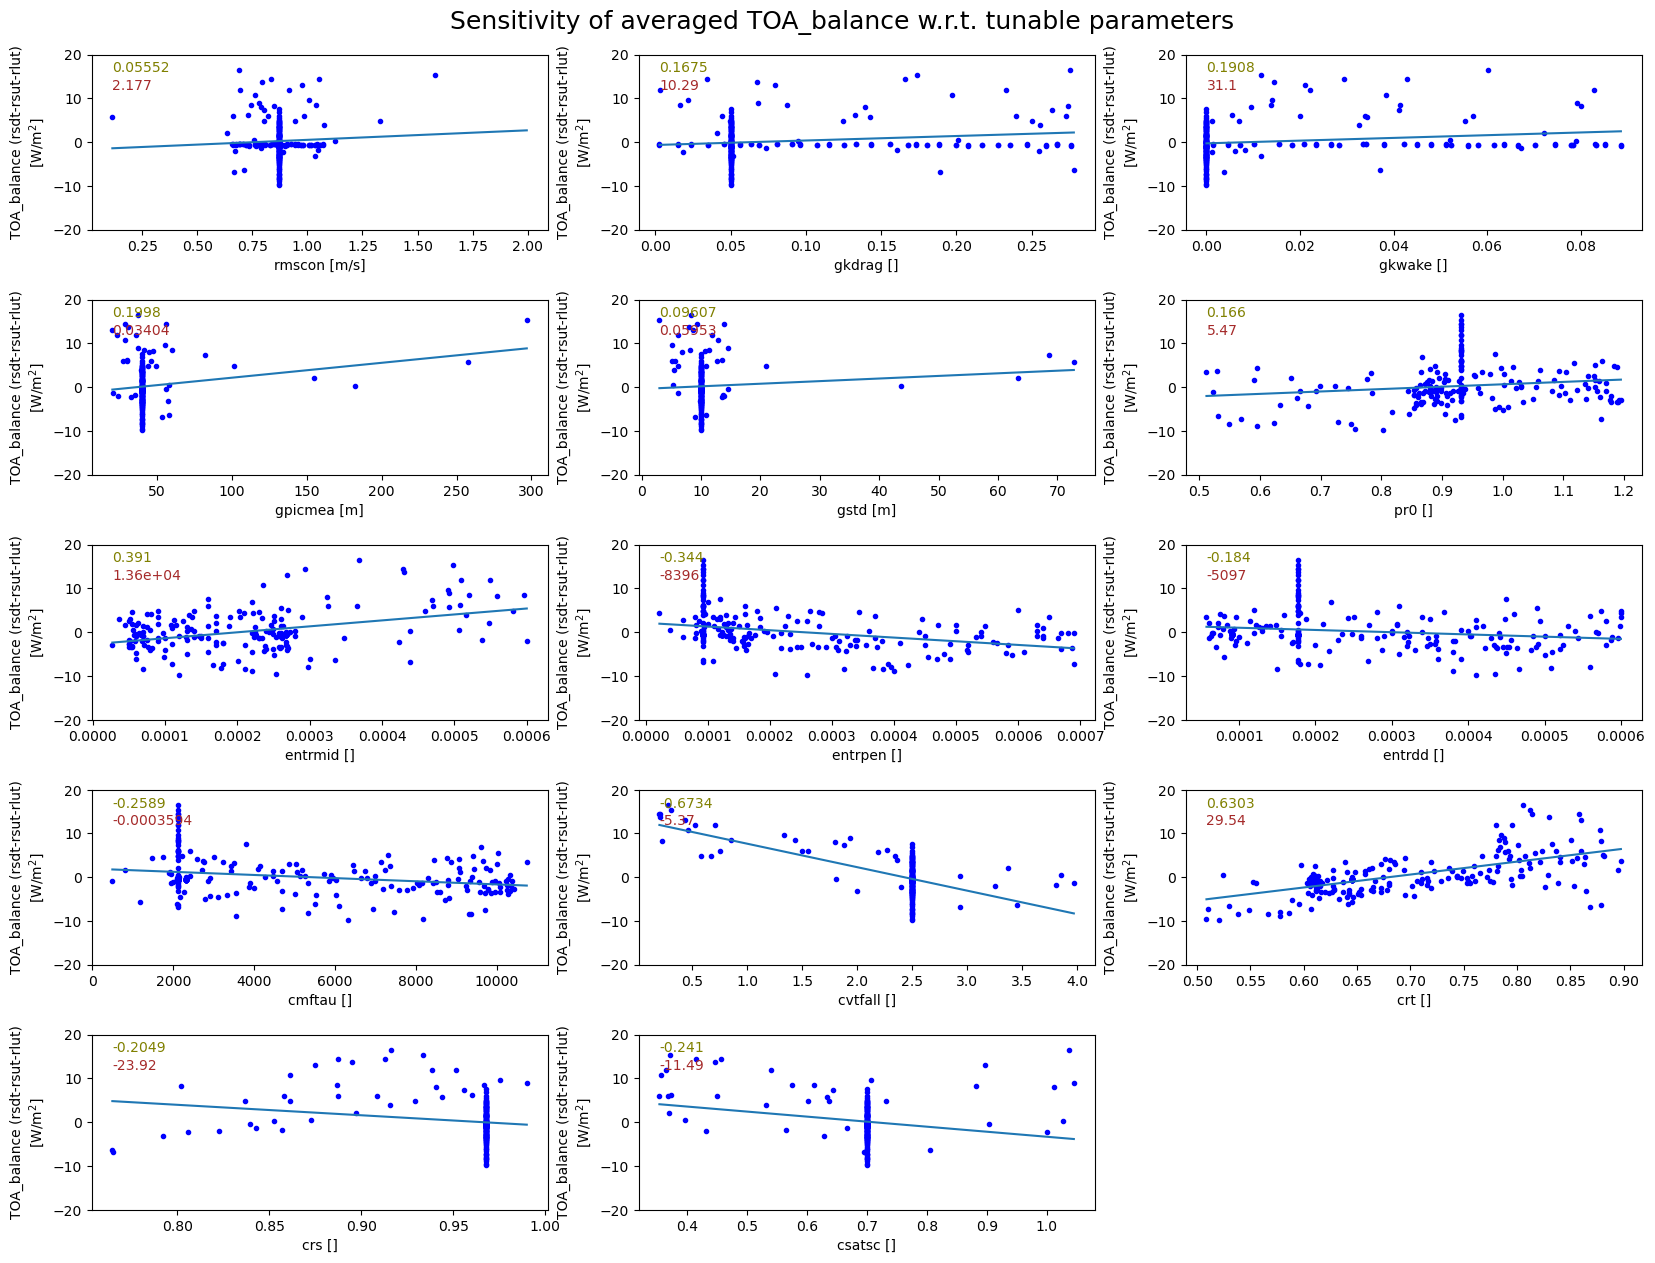

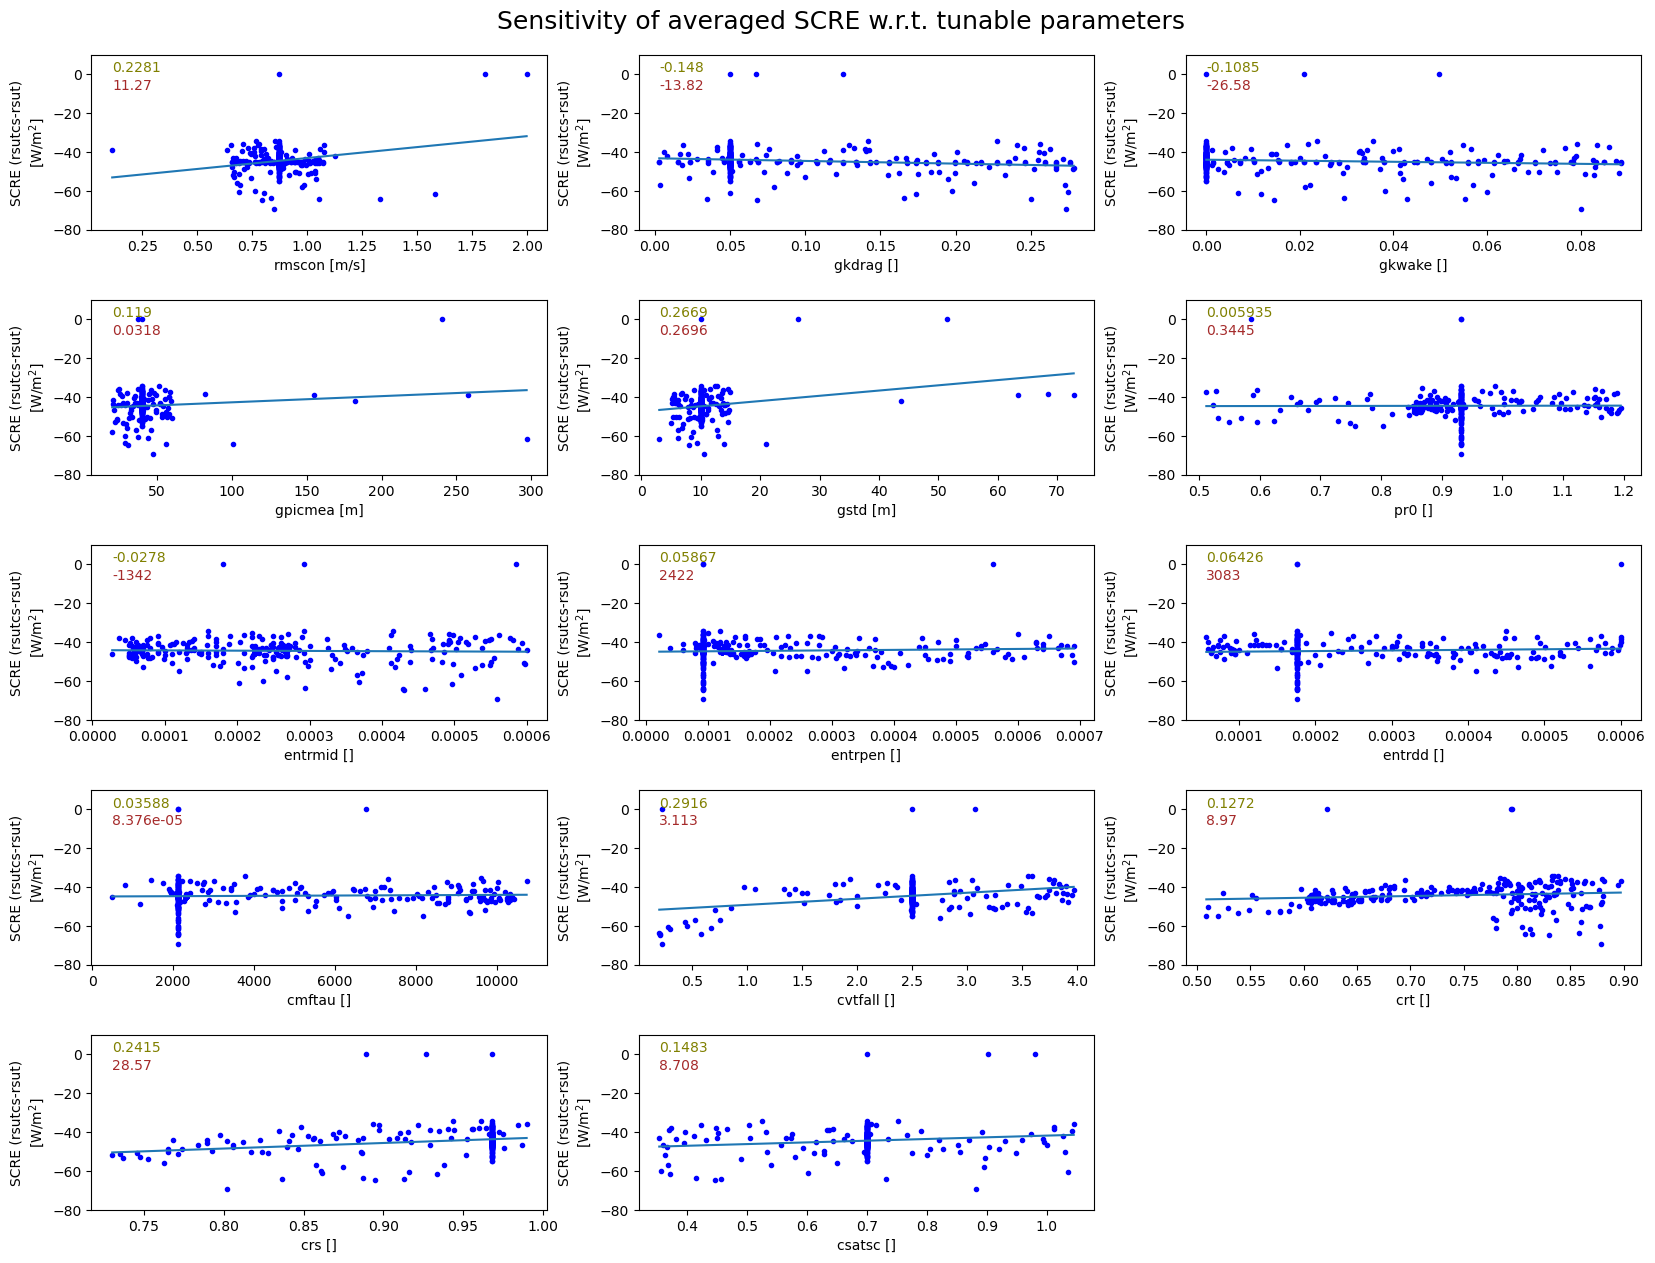

In [17]:
# Creating all sensitivity plots
create_sensitivity_plot('rlut', r'rlut [W/m$^2$]')
create_sensitivity_plot('rsut', r'rsut [W/m$^2$]')
create_sensitivity_plot('rsdt', r'rsdt [W/m$^2$]')
create_sensitivity_plot('clt', 'clt []')
create_sensitivity_plot('cllvi', r'cllvi [kg/m$^2$]')
create_sensitivity_plot('clivi', r'clivi [kg/m$^2$]')
create_sensitivity_plot('prw', r'prw [kg/m$^2$]')
create_sensitivity_plot('pr', r'pr [kg/(m$^2$s)]')
create_sensitivity_plot('net_SW', r'net_SW (rsdt-rsut) [W/m$^2$]')
create_sensitivity_plot('TOA_balance', "TOA_balance (rsdt-rsut-rlut)" "\n" r"[W/m$^2$]")
create_sensitivity_plot('SCRE', "SCRE (rsutcs-rsut)" "\n" r"[W/m$^2$]")

Number of simulations: 297
Number of simulations: 297
Number of simulations: 297


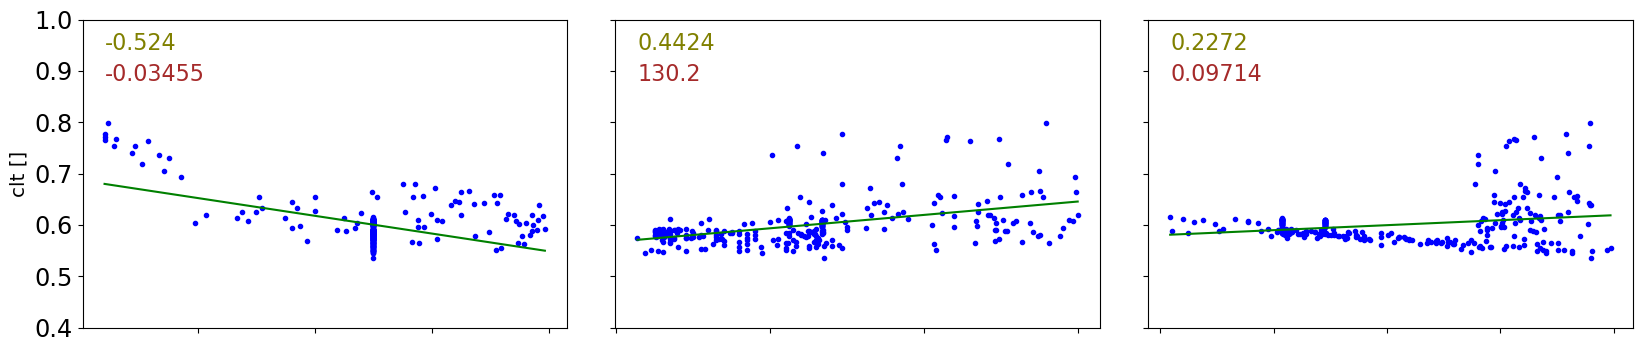

Number of simulations: 247
Number of simulations: 247
Number of simulations: 247


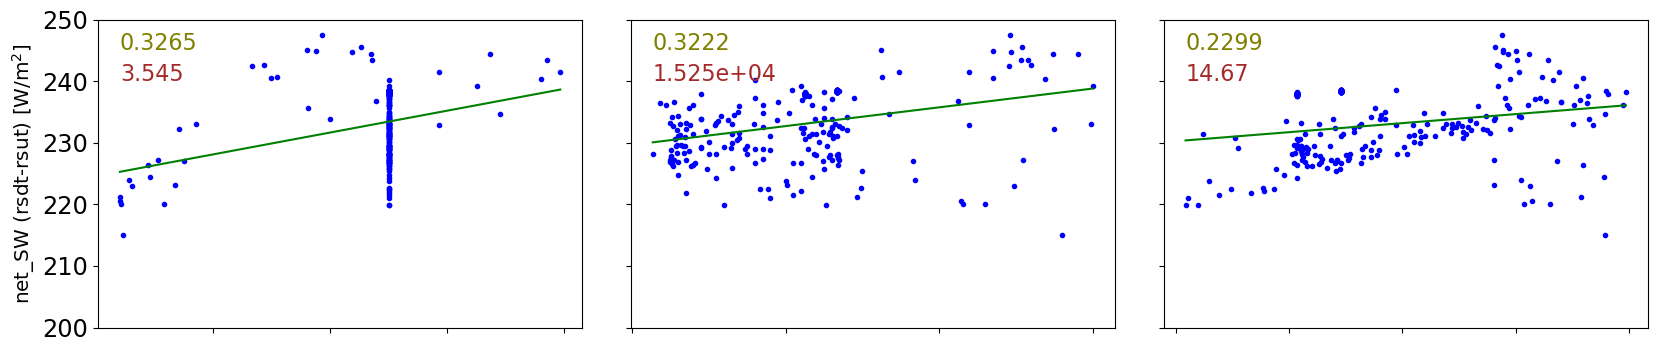

Number of simulations: 297
Number of simulations: 297
Number of simulations: 297


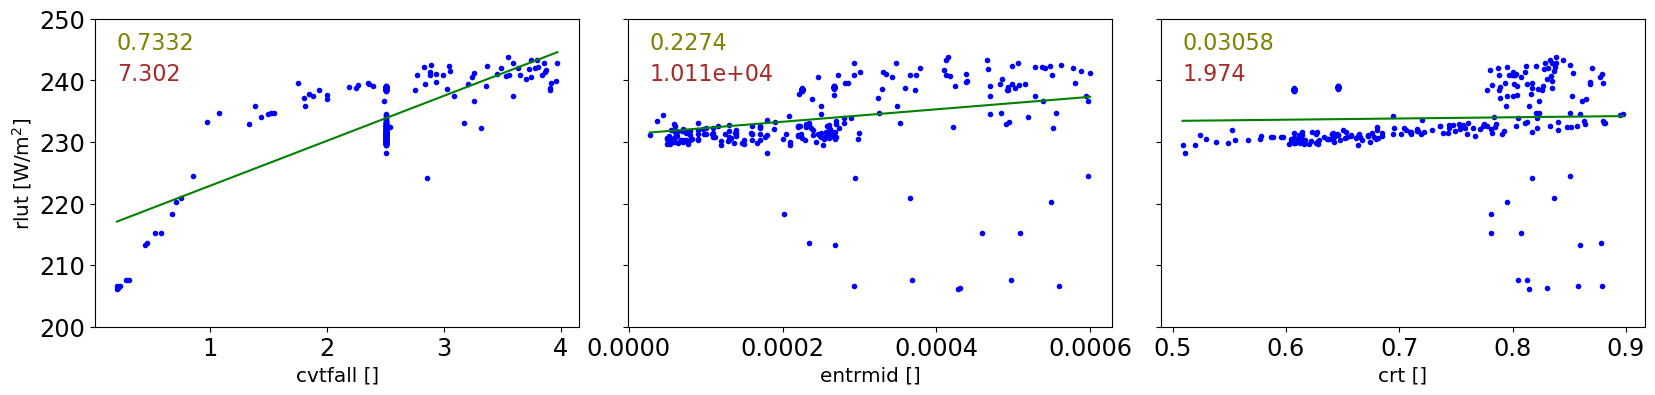

In [8]:
# For the paper
import matplotlib

# Increase the general font size
matplotlib.rcParams['legend.fontsize'] = 'x-large'
matplotlib.rcParams['axes.labelsize'] = 'x-large' # For an axes xlabel and ylabel
matplotlib.rcParams['axes.titlesize'] = 'x-large'
matplotlib.rcParams['xtick.labelsize'] = 'xx-large'
matplotlib.rcParams['ytick.labelsize'] = 'xx-large'

def create_sensitivity_plot_for_paper(metric, metric_with_unit):
    # Reading all results
    free_params = ['cvtfall', 'entrmid', 'crt'] 
    free_params_with_unit = ['cvtfall []', 'entrmid []', 'crt []']

    # Setting up the figure
    plt.figure(figsize=(20, 4))
    plt.subplots_adjust(hspace=0.4, wspace=0.1)

    # Setting up dict to store sign. slopes
    slopes_dict = {}
    slopes_dict[metric] = {}

    for i, free_param in enumerate(free_params):

        x_vals = []
        y_vals = []

        # Add new subplot iteratively
        ax = plt.subplot(1, 3, i + 1)

        for ppe in range(1, 11):
            try:
                x_vals_ppe, y_vals_ppe = extract_ppe_params_and_metric(ppe, free_param, metric)
                if len(x_vals) > 0:
                    x_vals = np.concatenate((x_vals, x_vals_ppe))
                    y_vals = np.concatenate((y_vals, y_vals_ppe))
                else:
                    x_vals = x_vals_ppe
                    y_vals = y_vals_ppe
            except:
                pass

        # Plotting
        print('Number of simulations: %d'%len(y_vals))
        ax.plot(x_vals, y_vals, 'b.')
        if metric == 'rlut':
            plt.xlabel(free_params_with_unit[i])
        if i == 0:
            plt.ylabel(metric_with_unit)

        # Adjust the ylim for each metric
        ylim_min, ylim_max = {
            'rlut': [200, 250],
            'rsut': [80, 140],
            'rsdt': [300, 400],
            'clt': [0.4, 1],
            'cllvi': [0, 0.2],
            'clivi': [0.02, 0.08],
            'prw': [10, 40],
            'pr': [2e-5, 5e-5],
            'net_SW': [200, 250],
            'SCRE': [-80, 10],
            'TOA_balance': [-20, 20]
        }.get(metric, [0, 1])

        plt.ylim([ylim_min, ylim_max])

        # Add linear regression line
        mask = (y_vals > ylim_min) & (y_vals < ylim_max)
        x_vals_cleaned = x_vals[mask]
        y_vals_cleaned = y_vals[mask]

        reg = LinearRegression().fit(x_vals_cleaned.reshape(-1, 1), y_vals_cleaned)
        X_lin = np.linspace(np.min(x_vals), np.max(x_vals), 100)
        plt.plot(X_lin, reg.coef_[0] * X_lin + reg.intercept_, color='green', ls='-')

        # Add the (linear) correlation coefficient as a number to the plot
        corr_coef = np.corrcoef(x_vals_cleaned, y_vals_cleaned)[0, 1]
        plt.text(np.min(x_vals), ylim_max - (ylim_max - ylim_min) / 10, '%.4g' % corr_coef, color='olive', fontsize=16)
        # Add slope of the regression line as a number to the plot
        reg_slope = reg.coef_[0]
        plt.text(np.min(x_vals), ylim_max - (ylim_max - ylim_min) / 5, '%.4g' % reg_slope, color='brown', fontsize=16)

        # Save all the slopes for significant correlations
        if np.abs(corr_coef) > 0.2:
            slopes_dict[metric][free_param] = reg_slope

        # Hide y-tick labels for all subplots except the first one
        if i != 0:
            ax.set_yticklabels([])

        # Hide x-tick labels for all subplots except for the specified metric
        if metric != 'rlut':
            ax.set_xticklabels([])

    plt.show()


create_sensitivity_plot_for_paper('clt', 'clt []')
create_sensitivity_plot_for_paper('net_SW', r'net_SW (rsdt-rsut) [W/m$^2$]')
create_sensitivity_plot_for_paper('rlut', r'rlut [W/m$^2$]')